In [19]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [15]:
## 데이터셋 생성
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                             centers=[[1,1],[-1,-1],[1,-1],[-1,1]],
                             shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                             centers=[[1,1],[-1,-1],[1,-1],[-1,1]],
                             shuffle=True, cluster_std=0.3)

In [16]:
# 2개의 레이블만 사용할 것이므로 4=>2
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0,1], 0)
y_train = label_map(y_train, [2,3], 1)
y_test = label_map(y_test, [0,1], 0)
y_test = label_map(y_test, [2,3], 1)

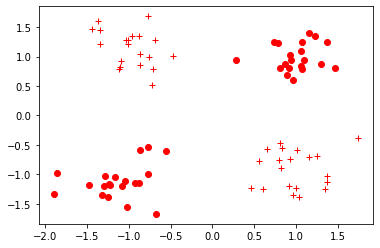

In [20]:
## 생성된 데이터셋 시각화
## 학습 데이터 생성
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*', markerfacecolor='none', makeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
            
    
plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [30]:
## 데이터셋을 파이토치 텐서로 변환
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [37]:
## 신경망 모델 정의
class NeuralNet(torch.nn.Module):
    # input_size는 신경망에 입력되는 데이터의 차원
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # input data가 인공신경망을 통과하면서 거치는 연산들 정의
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_tensor):
        # 입력데이터에 [input_size, hidden_size]크기의 가중치를 행렬곱하고 
        # 편향을 더하여 [1, hidden_size] 꼴의 텐서를 반환
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu) #[1,1]꼴로 변환
        output = self.sigmoid(linear2)
        return output

In [46]:
## 신경망 모델 생성 및 관련 변수와 알고리즘 정의
model = NeuralNet(2,5) #input_size=2, hidden_size=5
learning_rate = 0.03 #학습률 지정
criterion = torch.nn.BCELoss() #오차함수 준비(?), Binary Cross entropy 
epochs = 2000 #전체 학습 데이터를 총 몇번 모델에 입력할지 결정하는 변수
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #학습에 사용할 최적화 알고리즘 지정

In [47]:
# 학습 전 모델 성능 평가
model.eval()
#모델 결과값과 레이블값의 차원을 맞추기 위해 squeeze()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7074838876724243


In [48]:
## 성능 개선
## 신경망 학습
for epoch in range(epochs):
    model.train() # 학습모드로
    optimizer.zero_grad() #epoch마다 새로운 경사값 계산할 수 있도록 0으로 초기화
    train_output = model(x_train) #앞서 생성한 모델에 학습 데이터를 입력해 결과값 계산
    train_loss = criterion(train_output.squeeze(), y_train) #결과값의 차원을 레이블의 차원과 같게 만들고 오차를 계산
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    # 역전파
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7037522792816162
Train loss at 100 is 0.6188663244247437
Train loss at 200 is 0.527417778968811
Train loss at 300 is 0.4128904342651367
Train loss at 400 is 0.30975937843322754
Train loss at 500 is 0.23835185170173645
Train loss at 600 is 0.19058223068714142
Train loss at 700 is 0.15826484560966492
Train loss at 800 is 0.13476155698299408
Train loss at 900 is 0.1172608956694603
Train loss at 1000 is 0.10353275388479233
Train loss at 1100 is 0.0924413651227951
Train loss at 1200 is 0.08332321047782898
Train loss at 1300 is 0.07571648061275482
Train loss at 1400 is 0.06930100917816162
Train loss at 1500 is 0.06388689577579498
Train loss at 1600 is 0.05923141911625862
Train loss at 1700 is 0.055210359394550323
Train loss at 1800 is 0.05168922618031502
Train loss at 1900 is 0.04857787862420082


In [49]:
## 학습 후 모델 성능 평가
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.05338757112622261


In [50]:
## 학습된 가중치 저장
torch.save(model.state_dict(),'./model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-1.3405, -1.7894],
        [ 2.0021,  1.3637],
        [ 0.2666, -0.2740],
        [ 0.3385,  0.0368],
        [ 1.4241, -1.4696]])), ('linear_1.bias', tensor([-0.0154, -0.3667, -0.5982, -0.6596, -0.0976])), ('linear_2.weight', tensor([[-2.2411, -2.2712, -0.1465,  0.3817,  1.8596]])), ('linear_2.bias', tensor([2.1864]))])


In [51]:
## 저장된 가중치를 불러와 새로운 모델에 적용(전이 학습)
new_model = NeuralNet(2,5)
new_model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [52]:
new_model.eval()
print('벡터 [-1,1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1,1]이 레이블 1을 가질 확률은 0.8990219831466675
